# Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from catboost import CatBoostClassifier, Pool

# Intro

In this notebook aims to build a model that can predict whether a cellphone customer will cancel their subscription

# Data Loading & Prep

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/mkleinbort/resource-datasets/master/cell_phone_churn/cell_phone_churn.csv')

df_hold_out_set = df.iloc[::10, :]
df_hold_out_set.to_pickle('data/df_holdout.p')

df = df.drop(index=df_hold_out_set.index)

In [3]:
df.head()

,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,churn
1,OH,107,415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
5,AL,118,510,yes,no,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0,False


<AxesSubplot:ylabel='churn'>

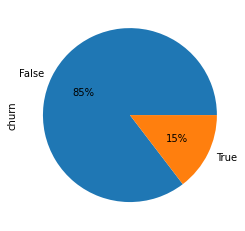

In [3]:
df['churn'].value_counts(normalize=True).plot(kind='pie', autopct=lambda x: f'{x:.0f}%')

# Model Development & Testing

In [4]:
from sklearn.model_selection import train_test_split

def get_Xy(df:pd.DataFrame) -> tuple:
    '''Returns (X, y, X_train, X_test, y_train, y_test, categorical_features)'''
    
    X = df.drop(columns=['churn'])
    y = df['churn'].astype(str)

    categorical_features = [i for i, dtype in enumerate(X.dtypes) if dtype == 'object']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

    return X, y, X_train, X_test, y_train, y_test, categorical_features

X, y, X_train, X_test, y_train, y_test, categorical_features = get_Xy(df)

In [5]:
y_test.value_counts(normalize=True)

False    0.841667
True     0.158333
Name: churn, dtype: float64

In [6]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(metric_period=100)

model.fit(X_train, y_train, cat_features=categorical_features)

Learning rate set to 0.014969
0:	learn: 0.6761291	total: 59.3ms	remaining: 59.2s
100:	learn: 0.2152338	total: 490ms	remaining: 4.36s
200:	learn: 0.1573327	total: 909ms	remaining: 3.61s
300:	learn: 0.1351645	total: 1.33s	remaining: 3.09s
400:	learn: 0.1213470	total: 1.75s	remaining: 2.61s
500:	learn: 0.1111228	total: 2.16s	remaining: 2.15s
600:	learn: 0.1018173	total: 2.58s	remaining: 1.71s
700:	learn: 0.0927837	total: 3.02s	remaining: 1.29s
800:	learn: 0.0842327	total: 3.46s	remaining: 858ms
900:	learn: 0.0762920	total: 3.78s	remaining: 415ms
999:	learn: 0.0697932	total: 4.11s	remaining: 0us


In [7]:
model.score(X_test, y_test)

0.96

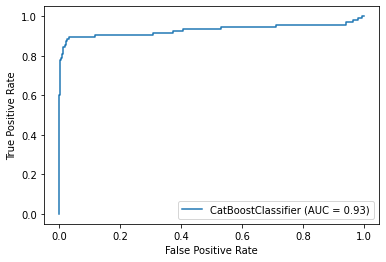

In [8]:
from sklearn.metrics import plot_roc_curve, roc_auc_score

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)


plot_roc_curve(model, X_test, y_test)

In [9]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.96      0.99      0.98       505
        True       0.95      0.79      0.86        95

    accuracy                           0.96       600
   macro avg       0.96      0.89      0.92       600
weighted avg       0.96      0.96      0.96       600



# Exporting the Model

In [10]:
model.fit(X, y, cat_features=categorical_features)

Learning rate set to 0.016467
0:	learn: 0.6781052	total: 12.3ms	remaining: 12.3s
100:	learn: 0.2028217	total: 363ms	remaining: 3.23s
200:	learn: 0.1483237	total: 643ms	remaining: 2.56s
300:	learn: 0.1289760	total: 924ms	remaining: 2.14s
400:	learn: 0.1173462	total: 1.19s	remaining: 1.78s
500:	learn: 0.1082947	total: 1.45s	remaining: 1.45s
600:	learn: 0.1019717	total: 1.71s	remaining: 1.14s
700:	learn: 0.0965252	total: 1.99s	remaining: 851ms
800:	learn: 0.0896938	total: 2.26s	remaining: 561ms
900:	learn: 0.0828129	total: 2.52s	remaining: 277ms
999:	learn: 0.0764873	total: 2.79s	remaining: 0us


In [11]:
model.save_model('catboost_model.cbm', format='cbm')